<a href="https://colab.research.google.com/github/jaytrey777/KMeans-Clustering-Find-K/blob/main/Analysis_of_KMeans_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

For this project, I will analyze the clusters I made in the KMeans: Find K Exercise.

Data source:
[Customer Segmentation with KMeans](https://github.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means)

Background:

The stakeholder is a credit card company that wants to market new credit cards. They have asked to segment their potential customers to determine how and what kind of cards they should market to each group.

Steps:

- Create analytical visualizations that explore statistics for each feature for each cluster.
- Write a description of each cluster, based on the visualizations created.
- Create one or two recommendations for the stakeholders regarding how they should market credit cards differently, or which cards they should market, to each cluster based on the data and insights.

# Imports & Drive Mounting

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
filename = '/content/drive/MyDrive/Colab Notebooks/03. Weeks 9-12: Advanced Machine Learning/09. Week 9: Clustering/5. Core Assignments/cust_seg.csv'
df = pd.read_csv(filename)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [5]:
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [6]:
df.describe()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,424.50000,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,0.00000,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,212.25000,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,424.50000,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,636.75000,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,849.00000,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


# Data Cleaning

I will drop the columns for Custome id and unnamed because they have no impact on the data we are trying to analyze.

In [7]:
df.drop(columns = ['Unnamed: 0', 'Customer Id'], inplace = True)
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


In [8]:
print(f' There are {df.duplicated().sum()} duplicaate rows in the data set') 

 There are 0 duplicaate rows in the data set


In [9]:
df.isna().sum()

Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

Since we dont have a way of verifying if the missing data defauted or not I am going to assume that the bank would know if a customer has defaulted on their loan and set them all to zero. 

In [10]:
df['Defaulted'].fillna(0, inplace = True)
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

# KMeans Customer Segments

## Instantiate Scaler

In [11]:
scaler = StandardScaler() #Instantiate Scaler
scaled_df = scaler.fit_transform(df) #fit it to the dataframs

## Elbow Method

In [12]:
inertia = [] #storage for inertias

for k in range(2,16): # Loop through k values 2-15 and store inertia results
    kmeans_elbow = KMeans(n_clusters=k, random_state = 42)  
    kmeans_elbow.fit(scaled_df)  
    inertia.append(kmeans_elbow.inertia_)

### Plot Results

Text(0, 0.5, 'inertia')

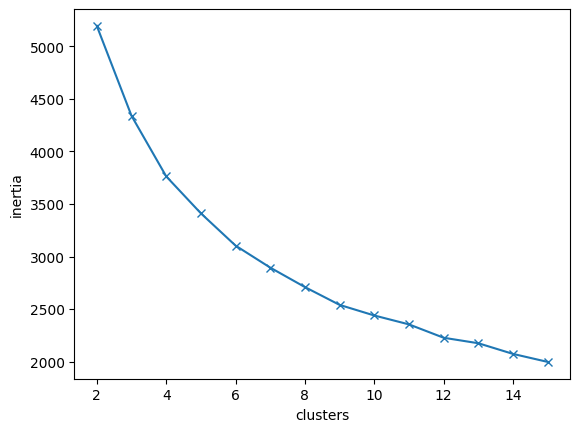

In [13]:
plt.plot(range(2,16), inertia, marker = 'x')
plt.xlabel('clusters')
plt.ylabel('inertia')

Based on this plot, the best number of clusters looks to be either 5 or 6.

## Silhouette Scores

In [14]:
silhouettes = [] # storage
for i in range(2, 16): # Loop through values 2-15
  kmeans_silhouette = KMeans(n_clusters = i, random_state = 42)
  kmeans_silhouette.fit(scaled_df)
  silhouettes.append(silhouette_score(scaled_df, kmeans_silhouette.labels_))

### Plot Results

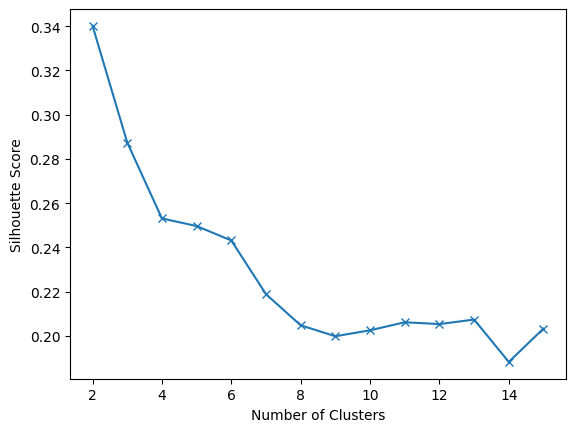

In [15]:
plt.plot(range(2, 16), silhouettes, marker = 'x')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Based on this plot, the best number of clusters looks to be either 2 or 3.

## KMeans Scores

### 2 Clusters

In [16]:
kmeans2 = KMeans(n_clusters = 2, random_state = 42)
kmeans2.fit(scaled_df)
silhouette_score(scaled_df, kmeans2.labels_)

0.3401172685946081

### 3 Clusters

In [17]:
kmeans3 = KMeans(n_clusters = 3, random_state = 42)
kmeans3.fit(scaled_df)
silhouette_score(scaled_df, kmeans3.labels_)

0.28738683325129355

### 5 Clusters

In [18]:
kmeans5 = KMeans(n_clusters = 5, random_state = 42)
kmeans5.fit(scaled_df)
silhouette_score(scaled_df, kmeans5.labels_)

0.2496481795475487

### 6 Clusters

In [22]:
kmeans6 = KMeans(n_clusters = 6, random_state = 42)
kmeans6.fit(scaled_df)
silhouette_score(scaled_df, kmeans6.labels_)

0.24311482556962066

## Analysis

Based on this data I would most likely make 6 clusters.  There are 850 rows in the data set, so this data set is rather small. 6 clusters also is where the delta starts to decrease using the elbow method.

# Analytical visualizations

In [32]:
# Refit KMeans with 6 clusters
kmeans = KMeans(n_clusters = 6, random_state = 42)
kmeans.fit(scaled_df)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
0,41,2,6,19,0.124,1.073,0.0,6.3,1
1,47,1,26,100,4.582,8.218,0.0,12.8,5
2,33,2,10,57,6.111,5.802,1.0,20.9,5
3,29,2,4,19,0.681,0.516,0.0,6.3,1
4,47,1,31,253,9.308,8.908,0.0,7.2,0


# 

In [31]:
clusters = df.groupby('cluster', as_index = False).mean()
clusters

,cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,46.285714,1.928571,22.642857,213.142857,11.737786,16.239857,0.571429,16.821429
1,1,31.807018,1.298246,5.748538,28.985380,0.711871,1.553386,0.000000,8.127485
2,2,41.753086,1.438272,16.604938,71.265432,1.438457,2.795253,0.012346,6.556173
3,3,33.534884,3.500000,4.895349,42.581395,1.018651,2.342977,0.069767,8.452326
4,4,31.503448,1.744828,3.558621,28.875862,1.399931,2.436090,1.000000,13.578621
5,5,39.930693,1.940594,13.574257,73.099010,4.048356,8.423574,0.217822,18.543564


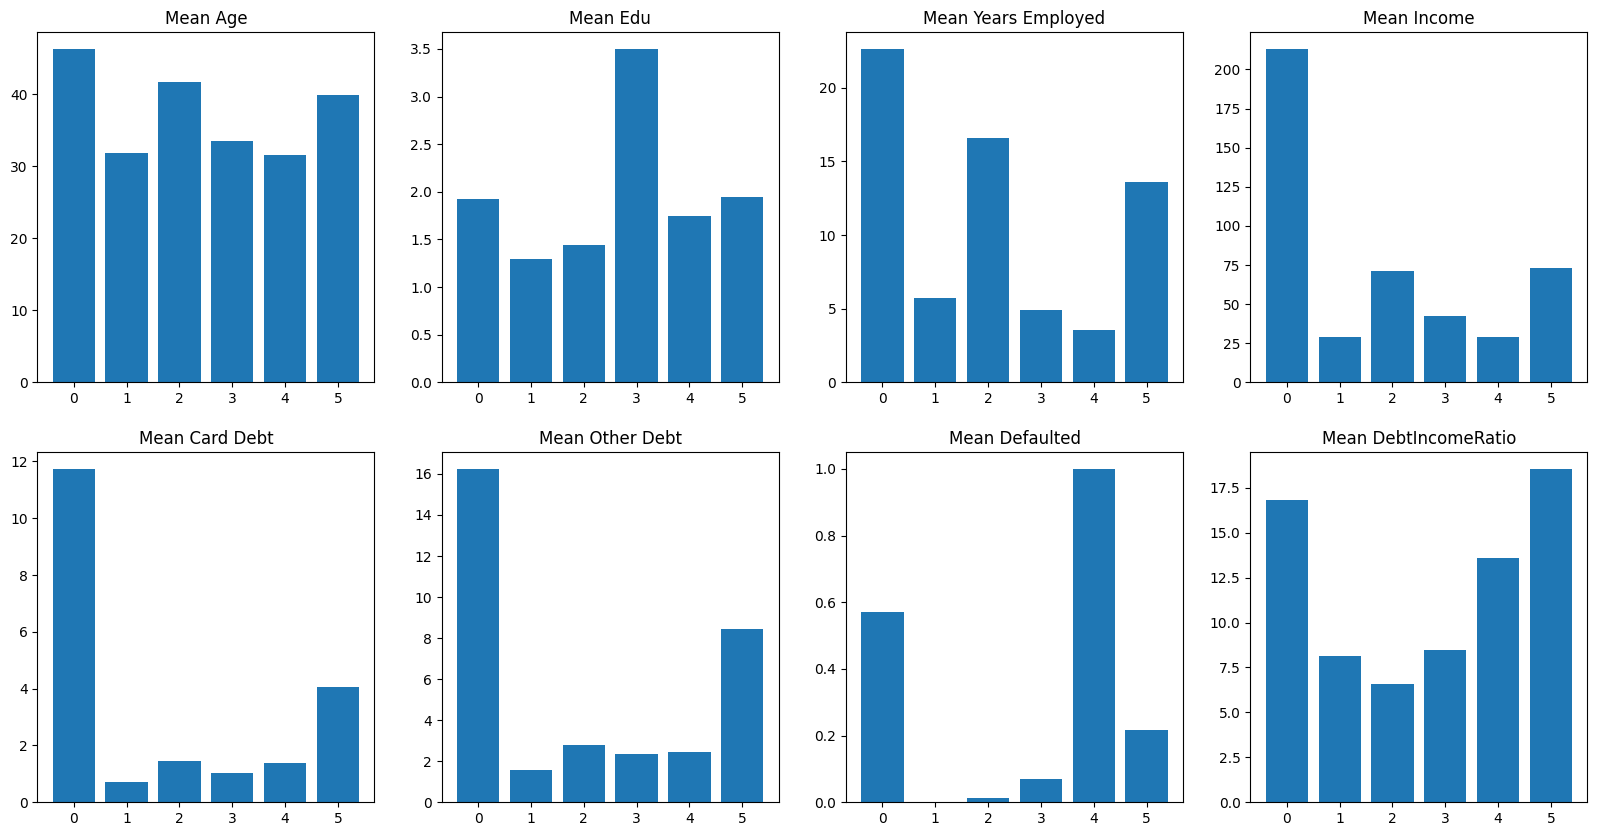

In [33]:
# Visualize means 
fig, axes = plt.subplots(2,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, column in enumerate(clusters.columns[1:]):
  axes[i].bar(clusters['cluster'], clusters[column])
  axes[i].set_title(f'Mean {column}')

## Cluster descriptions

### Cluster 0

Cluster 0:

*   Oldest
*   3rd highest educated
*   Longest employed
*   Highest Income
*   Most card debt
*   Most other debt
*   2nd highest defaulted cards
*   2nd highest debt to income ratio

These people are the oldest and have a lot of work experience, but they have a lot of debt. They also have a high debt to income ratio, but the dont pay back a lot of debt since they have defaulted on their cards. 


### Cluster 1

Cluster 1:

*   2nd youngest
*   Least educated
*   4th longest employed
*   Least income
*   Least amount of card debt
*   Least amount of other debt
*   Least amount of defaulted cards
*   2nd lowest debt to income ratio

These people are younger without a lot of education.  They have very little debt, but they also make the least amount of money. They also have a low debt to income ratio.

### Cluster 2

Cluster 2:

*   2nd oldest
*   2nd least educated
*   2nd longest employed
*   3rd highest income
*   3rd highest amount of card debt
*   3rd highest amount of other debt
*   2nd lowest amount of defaulted cards
*   Least debt to income ratio

These people are older with a lot of experience, but a low amount of debt. They also have a low debt to income ratio and don't default on their cards.

### Cluster 3

Cluster 3:

*   3rd youngest
*   Most educated
*   5th longest employed
*   4th highest income
*   5th highest amount of card debt
*   5th highest amount of other debt
*   3rd lowest amount of defaulted cards
*   3rd lowest debt to income ratio

These people are young with high education.  They have not been in the workforce for a long time, but it seems like they use their credit dards.

### Cluster 4

Cluster 4:

*   Youngest
*   4th highest educated
*   Least time employed
*   2nd lowest income
*   4th highest amount of card debt
*   4th highest amount of other debt
*   Most defaulted cards
*   3rd highest debt to income ratio

These people are young with decent education.  They have not been in the workforce for a long time and do not make a lot of money. They do use their credit cards and take on a moderate amount of debt, but they are likely to default on their cards. 

### Cluster 5

Cluster 5:

*   3rd oldest
*   2nd highest educated
*   3rd longest employed
*   2nd highest income
*   2nd highest amount of card debt
*   2nd highest amount of other debt
*   3rd highest amount of defaulted cards
*   Highest debt to income ratio

These people are older with decent education.  They have been in the workforce awhile and make a decent amount of money. They do use their credit cards and take on a lot of debt, but they are likely to default on their cards. 

#Recommendations

I would recommend 2 types of cards:

1.   A card to Group 2 that would encourage them to spend becaue they have disposable income because they have a good income and they are not likely to default on the cards. 

2.   A card to group 5 to encourage them to consoldate their debt to our cards becasue they are not likely to default their cards. Although their debt to income ratio is high, they could be incouraged to move their debt to another card as a means to help.

